In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.ar_model import AutoReg

In [2]:
def ma_model(epsilon_prev, const, theta, sigma2):
    """ X_t = const + epsilon_t + theta * epsilon_{t-1} """

    epsilon_t = np.random.normal(loc=0, scale=np.sqrt(sigma2))
    next_logr = const + epsilon_t + theta * epsilon_prev

    return next_logr

# Round 1

In [3]:
price_0 = pd.read_csv('../data/raw/round_1/prices_round_1_day_-2.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_1/prices_round_1_day_-1.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_1/prices_round_1_day_0.csv', delimiter=';')

In [4]:
price_0 = price_0[price_0['product'] == 'SQUID_INK']
price_1 = price_1[price_1['product'] == 'SQUID_INK']
price_2 = price_2[price_2['product'] == 'SQUID_INK']

In [5]:
trades_0 = pd.read_csv('../data/raw/round_1/trades_round_1_day_-2.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_1/trades_round_1_day_-1.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_1/trades_round_1_day_0.csv', delimiter=';')

In [6]:
trades_0 = trades_0[trades_0['symbol'] == 'SQUID_INK']
trades_1 = trades_1[trades_1['symbol'] == 'SQUID_INK']
trades_2 = trades_2[trades_2['symbol'] == 'SQUID_INK']

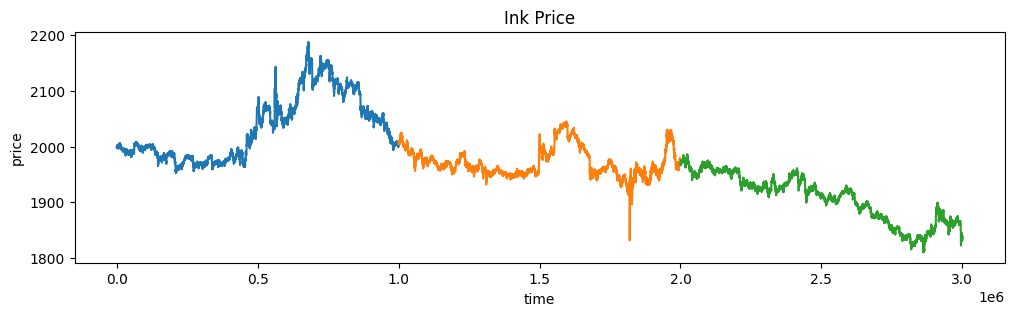

In [7]:
plt.figure(figsize=(12, 3))
plt.plot(price_0['timestamp'], price_0['mid_price'])
plt.plot(price_1['timestamp'] + 1000000, price_1['mid_price'])
plt.plot(price_2['timestamp'] + 2000000, price_2['mid_price'])
plt.title('Ink Price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [8]:
prices = pd.concat([price_0, price_1, price_2], axis=0).reset_index(drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).reset_index(drop=True)

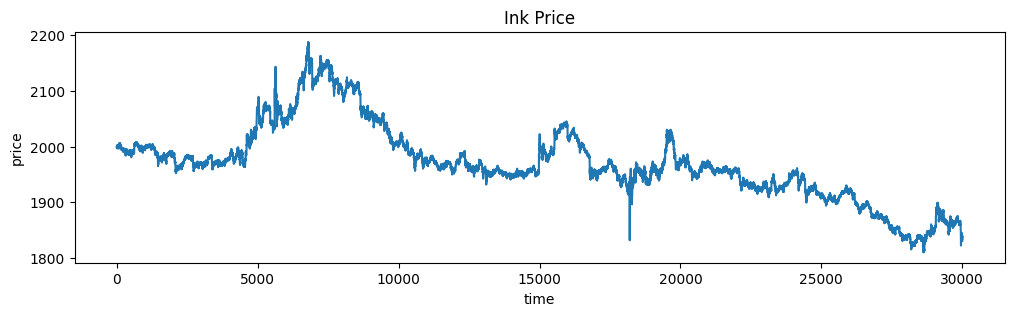

In [9]:
plt.figure(figsize=(12, 3))
plt.plot(prices['mid_price'])
plt.title('Ink Price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [10]:
bid_prices = prices[['bid_price_1', 'bid_price_2', 'bid_price_3']].to_numpy()
max_inds = prices[['bid_volume_1', 'bid_volume_2', 'bid_volume_3']].idxmax(axis=1).apply(lambda x: int(x[-1]) - 1).to_numpy()
pop_bid_prices = bid_prices[np.arange(len(bid_prices)), max_inds]

ask_prices = prices[['ask_price_1', 'ask_price_2', 'ask_price_3']].to_numpy()
max_inds = prices[['ask_volume_1', 'ask_volume_2', 'ask_volume_3']].idxmax(axis=1).apply(lambda x: int(x[-1]) - 1).to_numpy()
pop_ask_prices = ask_prices[np.arange(len(ask_prices)), max_inds]

prices = prices.assign(pop_bid_price=pop_bid_prices)
prices = prices.assign(pop_ask_price=pop_ask_prices)
prices = prices.assign(pop_mid_price=(pop_bid_prices + pop_ask_prices) / 2)

In [243]:
filtered_mid_prices = []
for i in range(prices.shape[0]):
    price = prices.iloc[i]
    bid_prices = price[['bid_price_1', 'bid_price_2', 'bid_price_3']].to_numpy()
    bid_volumes = price[['bid_volume_1', 'bid_volume_2', 'bid_volume_3']].to_numpy()
    bids = dict(zip(bid_prices, bid_volumes))
    ask_prices = price[['ask_price_1', 'ask_price_2', 'ask_price_3']].to_numpy()
    ask_volumes = price[['ask_volume_1', 'ask_volume_2', 'ask_volume_3']].to_numpy()
    asks = dict(zip(ask_prices, ask_volumes))
    
    filtered_asks = [price for price in asks if abs(asks[price]) >= 15]
    filtered_bids = [price for price in bids if abs(bids[price]) >= 15]
    best_filtered_ask = min(filtered_asks) if len(filtered_asks) > 0 else None
    best_filtered_bid = max(filtered_bids) if len(filtered_bids) > 0 else None

    if best_filtered_ask and best_filtered_bid:
        filtered_mid_price = (best_filtered_ask + best_filtered_bid) / 2
    else:
        filtered_mid_price = price['mid_price']
    filtered_mid_prices.append(filtered_mid_price)
prices = prices.assign(filtered_mid_price=filtered_mid_prices)

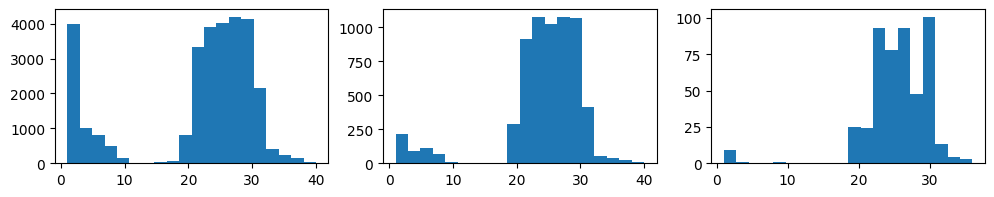

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
ax[0].hist(prices['bid_volume_1'], bins=20)
ax[1].hist(prices['bid_volume_2'], bins=20)
ax[2].hist(prices['bid_volume_3'], bins=20)
plt.show()

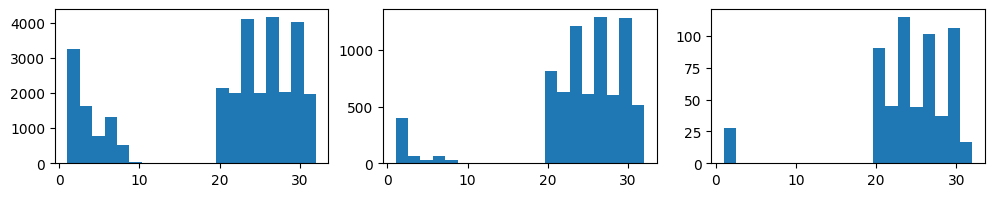

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
ax[0].hist(prices['ask_volume_1'], bins=20)
ax[1].hist(prices['ask_volume_2'], bins=20)
ax[2].hist(prices['ask_volume_3'], bins=20)
plt.show()

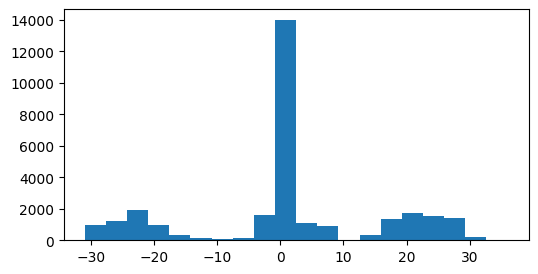

In [14]:
plt.figure(figsize=(6, 3))
plt.hist(prices['bid_volume_1'] - prices['ask_volume_1'], bins=20)
plt.show()

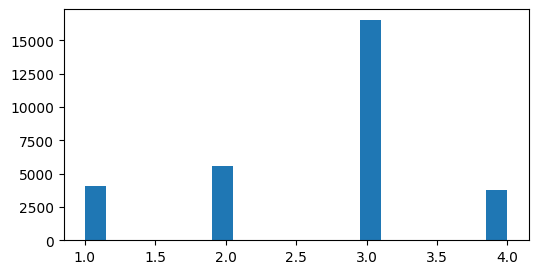

In [15]:
plt.figure(figsize=(6, 3))
plt.hist(prices['ask_price_1'] - prices['bid_price_1'], bins=20)
plt.show()

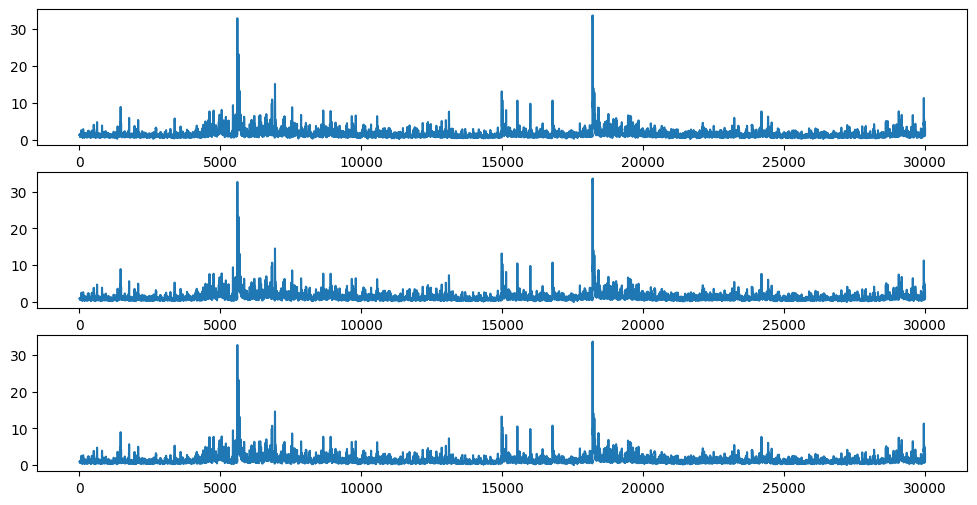

In [244]:
fig, ax = plt.subplots(3, 1, figsize=(12, 6))
ax[0].plot(prices['mid_price'].rolling(10).std())
ax[1].plot(prices['pop_mid_price'].rolling(10).std())
ax[2].plot(prices['filtered_mid_price'].rolling(10).std())
plt.show()

In [245]:
price = prices.iloc[:100]

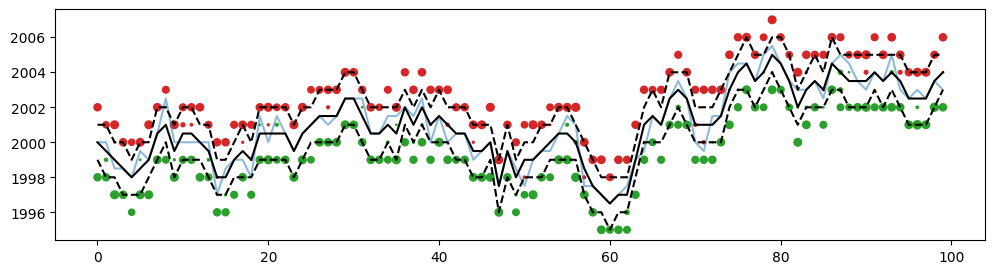

In [246]:
plt.figure(figsize=(12, 3))
plt.scatter(price['timestamp']//100, price['bid_price_1'], s=price['bid_volume_1'], c='tab:green')
plt.scatter(price['timestamp']//100, price['bid_price_2'], s=price['bid_volume_2'], c='tab:green')
plt.scatter(price['timestamp']//100, price['bid_price_3'], s=price['bid_volume_3'], c='tab:green')
plt.scatter(price['timestamp']//100, price['ask_price_1'], s=price['ask_volume_1'], c='tab:red')
plt.scatter(price['timestamp']//100, price['ask_price_2'], s=price['ask_volume_2'], c='tab:red')
plt.scatter(price['timestamp']//100, price['ask_price_3'], s=price['ask_volume_3'], c='tab:red')
plt.plot(price['timestamp']//100, price['mid_price'], c='tab:blue', alpha=0.5)
plt.plot(price['timestamp']//100, price['filtered_mid_price'], c='k')
plt.plot(price['timestamp']//100, np.floor(price['filtered_mid_price']) - 1, c='k', linestyle='dashed')
plt.plot(price['timestamp']//100, np.ceil(price['filtered_mid_price']) + 1, c='k', linestyle='dashed')
plt.show()

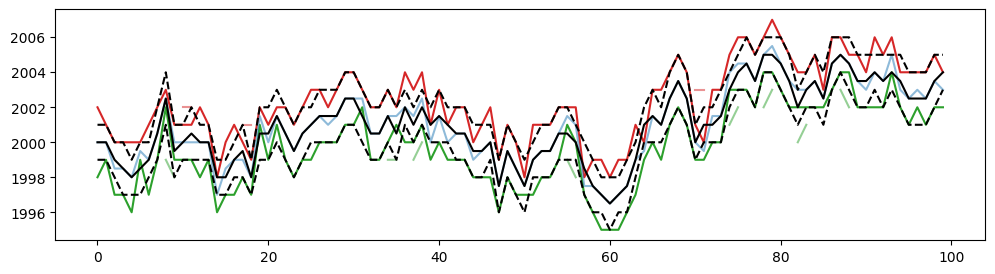

In [241]:
plt.figure(figsize=(12, 3))
plt.plot(price['timestamp']//100, price['bid_price_1'], c='tab:green')
plt.plot(price['timestamp']//100, price['bid_price_2'], c='tab:green', alpha=0.5)
plt.plot(price['timestamp']//100, price['bid_price_3'], c='tab:green', alpha=0.5)
plt.plot(price['timestamp']//100, price['ask_price_1'], c='tab:red')
plt.plot(price['timestamp']//100, price['ask_price_2'], c='tab:red', alpha=0.5)
plt.plot(price['timestamp']//100, price['ask_price_3'], c='tab:red', alpha=0.5)
plt.plot(price['timestamp']//100, price['mid_price'], c='tab:blue', alpha=0.5)
plt.plot(price['timestamp']//100, price['filtered_mid_price'], c='k')
plt.plot(price['timestamp']//100, np.floor(price['filtered_mid_price']) - 1, c='k', linestyle='dashed')
plt.plot(price['timestamp']//100, np.ceil(price['filtered_mid_price']) + 1, c='k', linestyle='dashed')
plt.show()

## Analysis

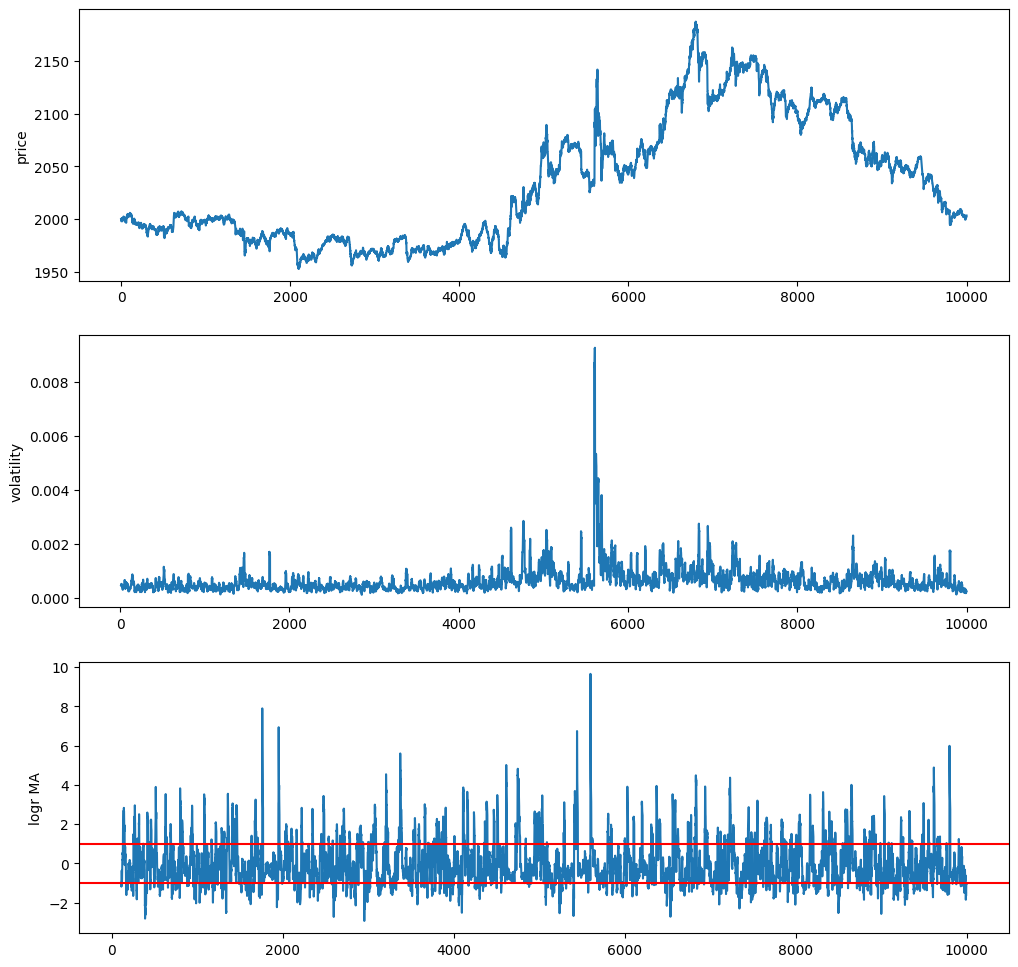

In [283]:
train = prices['filtered_mid_price'].iloc[:prices.shape[0] // 3]
valid = prices['filtered_mid_price'].iloc[prices.shape[0] // 3:prices.shape[0] // 3 * 2]
test = prices['filtered_mid_price'].iloc[prices.shape[0] // 3 * 2:]

train_logr = np.log(train.shift(1) / train)
valid_logr = np.log(valid.shift(1) / valid)
test_logr = np.log(test.shift(1) / test)

train_vol = train_logr.rolling(10).std().dropna()
valid_vol = valid_logr.rolling(10).std().dropna()
test_vol = test_logr.rolling(10).std().dropna()

train_vol_z = (train_vol - train_vol.rolling(100).mean()) / train_vol.rolling(100).std()

vol_thr = 1

fig, ax = plt.subplots(3, 1, figsize=(12, 12))
ax[0].plot(train)
ax[1].plot(train_vol)
ax[2].plot(train_vol_z)
ax[2].axhline(vol_thr, c='r')
ax[2].axhline(-vol_thr, c='r')
ax[0].set_ylabel('price')
ax[1].set_ylabel('volatility')
ax[2].set_ylabel('logr MA')
plt.show()

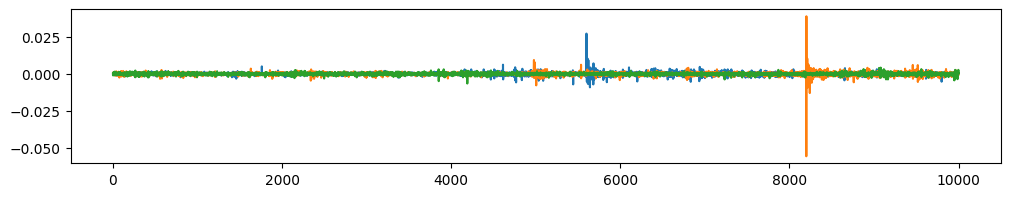

In [201]:
plt.figure(figsize=(12, 2))
plt.plot(train_logr)
plt.plot(valid_logr)
plt.plot(test_logr)
plt.show()

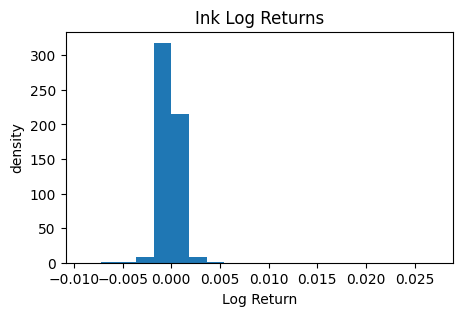

In [191]:
plt.figure(figsize=(5, 3))
plt.hist(train_logr, bins=20, density=True)
plt.title('Ink Log Returns')
plt.xlabel('Log Return')
plt.ylabel('density')
plt.show()

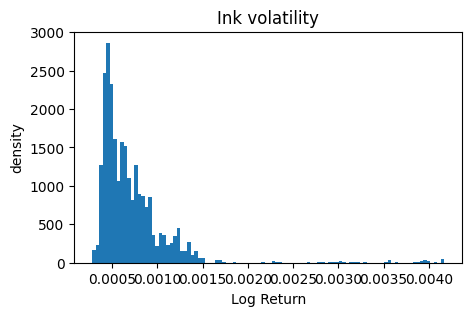

In [192]:
plt.figure(figsize=(5, 3))
plt.hist(train_vol, bins=100, density=True)
plt.title('Ink volatility')
plt.xlabel('Log Return')
plt.ylabel('density')
plt.show()

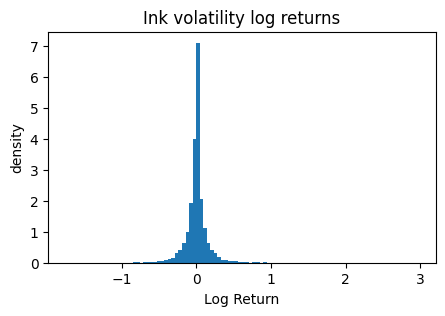

In [193]:
plt.figure(figsize=(5, 3))
plt.hist(train_vol_logr, bins=100, density=True)
plt.title('Ink volatility log returns')
plt.xlabel('Log Return')
plt.ylabel('density')
plt.show()

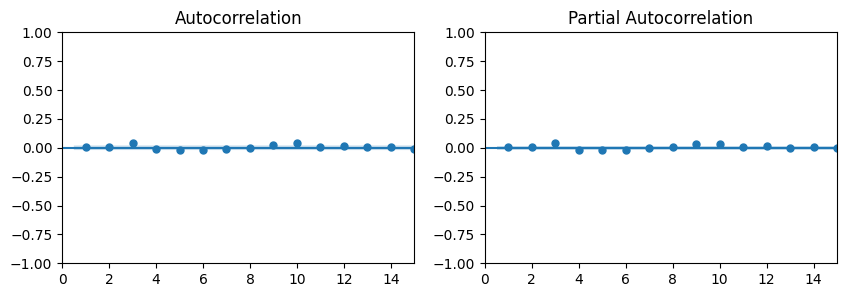

In [194]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(train_logr, ax=ax[0], zero=False)
plot_pacf(train_logr, ax=ax[1], zero=False)
ax[0].set_xlim([0, 15])
ax[1].set_xlim([0, 15])
plt.show()

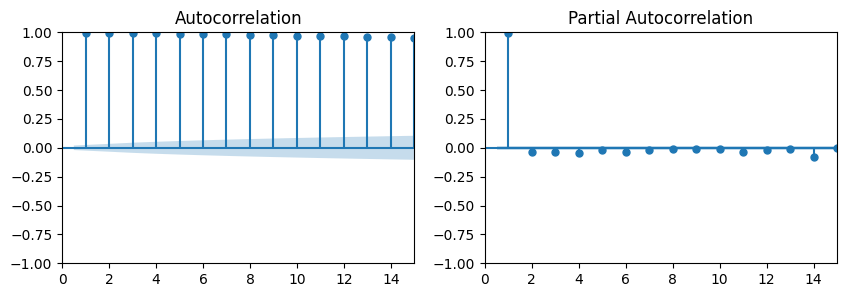

In [195]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(train_vol, ax=ax[0], zero=False)
plot_pacf(train_vol, ax=ax[1], zero=False)
ax[0].set_xlim([0, 15])
ax[1].set_xlim([0, 15])
plt.show()

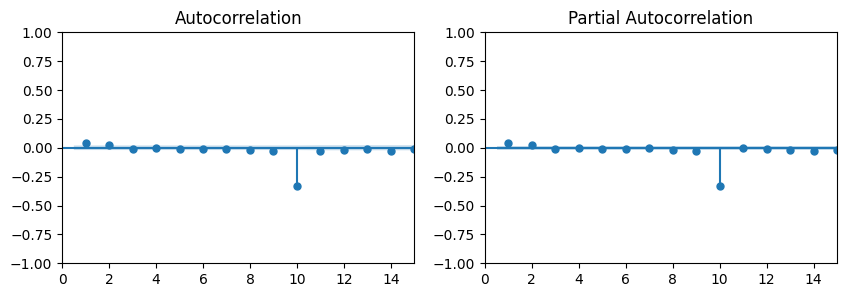

In [196]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(train_vol_logr, ax=ax[0], zero=False)
plot_pacf(train_vol_logr, ax=ax[1], zero=False)
ax[0].set_xlim([0, 15])
ax[1].set_xlim([0, 15])
plt.show()

-> AR(1) model for volatility?

In [46]:
# Perform Ljung-Box test for lags up to 10
result = acorr_ljungbox(train_logr, lags=[10], return_df=True)
print(result)

# Interpretation
if result['lb_pvalue'].values[0] > 0.05:
    print("Fail to reject null hypothesis: data may be white noise.")
else:
    print("Reject null hypothesis: data is not white noise.")

      lb_stat     lb_pvalue
10  51.489305  1.418377e-07
Reject null hypothesis: data is not white noise.


In [47]:
# Perform Ljung-Box test for lags up to 10
result = acorr_ljungbox(train_vol, lags=[10], return_df=True)
print(result)

# Interpretation
if result['lb_pvalue'].values[0] > 0.05:
    print("Fail to reject null hypothesis: data may be white noise.")
else:
    print("Reject null hypothesis: data is not white noise.")

         lb_stat  lb_pvalue
10  56373.528291        0.0
Reject null hypothesis: data is not white noise.


## Volatility prediction

### Naive

In [89]:
err = valid_vol[1:] - valid_vol[:-1]
rmse = np.mean(err ** 2) ** 0.5
print(f'Validation RMSE: {rmse}')

Validation RMSE: 0.00024141496743692234


In [90]:
err = test_vol[1:] - test_vol[:-1]
rmse = np.mean(err ** 2) ** 0.5
print(f'Test RMSE: {rmse}')

Test RMSE: 8.057757314519068e-05


### AR(1)

In [96]:
coeffs = np.polyfit(train_vol[:-1], train_vol[1:], deg=1)
a, b = coeffs

In [97]:
print(a, b)

0.9569647321659633 2.803629954549409e-05


In [98]:
preds = valid_vol[:-1] * a

In [100]:
err = valid_vol[1:] - preds
rmse = np.mean(err ** 2) ** 0.5
print(f'Validation RMSE: {rmse}')

Validation RMSE: 0.00024059356812177902


In [101]:
preds = test_vol[:-1] * a

In [102]:
err = test_vol[1:] - preds
rmse = np.mean(err ** 2) ** 0.5
print(f'Test RMSE: {rmse}')

Test RMSE: 8.277045104451094e-05


## Price prediction - Filtered orders

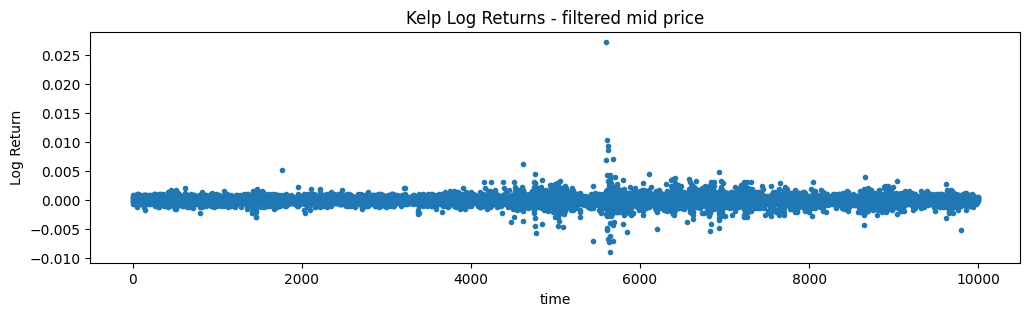

In [203]:
train = prices['filtered_mid_price'].iloc[:prices.shape[0] // 3].to_numpy()
valid = prices['filtered_mid_price'].iloc[prices.shape[0] // 3:prices.shape[0] // 3 * 2].to_numpy()
test = prices['filtered_mid_price'].iloc[prices.shape[0] // 3 * 2:].to_numpy()

train_logr = np.log(train[1:] / train[:-1])
valid_logr = np.log(valid[1:] / valid[:-1])
test_logr = np.log(test[1:] / test[:-1])

plt.figure(figsize=(12, 3))
plt.scatter(np.arange(len(train_logr)), train_logr, marker='.')
plt.title('Kelp Log Returns - filtered mid price')
plt.xlabel('time')
plt.ylabel('Log Return')
plt.show()

### Naive

In [204]:
rmse = np.mean(valid_logr ** 2) ** 0.5
print(f'Log-returns RMSE: {rmse}')

y = valid[1:]
y_pred = valid[:-1]
err = y - y_pred
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE: {rmse}')

Log-returns RMSE: 0.001040434023618126
Price RMSE: 2.0069698036540755


In [205]:
rmse = np.mean(test_logr ** 2) ** 0.5
print(f'Log-returns RMSE - test set: {rmse}')

y = test[1:]
y_pred = test[:-1]
err = y - y_pred
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE - test set: {rmse}')

Log-returns RMSE - test set: 0.0005854760301140691
Price RMSE - test set: 1.115089387643091


### AR(1)

In [248]:
def reg_param(x):
    return np.polyfit(x[:-1], x[1:], deg=1)[0]

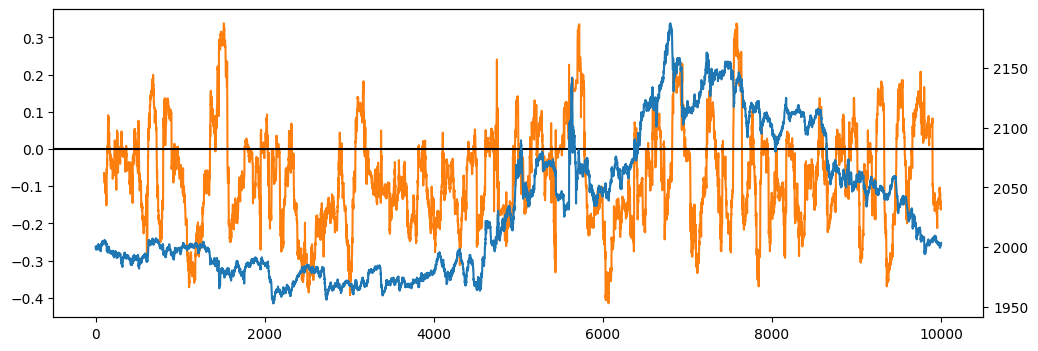

In [268]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(pd.Series(train_logr).rolling(100).apply(reg_param), c='tab:orange')
ax.axhline(0, c='k')
ax2 = ax.twinx()
ax2.plot(train)
plt.show()

In [206]:
coeffs = np.polyfit(train_logr[:-1], train_logr[1:], deg=1)
a, b = coeffs
print(a, b)

0.0076670353993473885 1.9854933025131493e-07


In [207]:
preds = valid_logr[:-1] * a

In [208]:
pred_price = valid[1:-1] * np.exp(preds)

In [209]:
err = valid_logr[1:] - preds
rmse = np.mean(err ** 2) ** 0.5
print(f'Log-returns RMSE: {rmse}')

err = valid[2:] - pred_price
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE: {rmse}')

Log-returns RMSE: 0.0010420473757129342
Price RMSE: 2.0098681794527686


In [210]:
preds = test_logr[:-1] * a

In [211]:
pred_price = test[1:-1] * np.exp(preds)

In [212]:
err = test_logr[1:] - preds
rmse = np.mean(err ** 2) ** 0.5
print(f'Log-returns RMSE - test set: {rmse}')

err = test[2:] - pred_price
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE - test set: {rmse}')

Log-returns RMSE - test set: 0.0005859225244206383
Price RMSE - test set: 1.115951248957481


In [215]:
from sklearn.linear_model import LinearRegression

In [216]:
train_logr.shape

(9999,)

In [218]:
x_train = pd.DataFrame({
    'timestamp': np.arange(len(train_logr) - 1),  # Current timestamp
    'current_log_return': train_logr[:-1]  # Current log return
})
y_train = train_logr[1:]  # Next log return (target)

x_valid = pd.DataFrame({
    'timestamp': np.arange(len(valid_logr) - 1),  # Current timestamp
    'current_log_return': valid_logr[:-1]  # Current log return
})
y_valid = valid_logr[1:]  # Next log return (target)

In [220]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [226]:
print("Intercept:", model.intercept_)
print("Coefficients:", dict(zip(X.columns, model.coef_)))

Intercept: 9.545439646983333e-06
Coefficients: {'timestamp': np.float64(-1.8699375506004606e-09), 'current_log_return': np.float64(0.007624320572602102)}


In [136]:
preds = np.matmul(x, result.params[1:].T)

In [138]:
pred_price = valid[10:-1] * np.exp(preds)

In [139]:
err = valid_logr[10:] - preds
rmse = np.mean(err ** 2) ** 0.5
print(f'Log-returns RMSE: {rmse}')

err = valid[11:] - pred_price
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE: {rmse}')

Log-returns RMSE: 0.0010433125723645735
Price RMSE: 2.0128074297067053


In [51]:
np.mean([np.polyfit(train_logr[:-1], train_logr[1:], deg=1)[0],
         np.polyfit(valid_logr[:-1], valid_logr[1:], deg=1)[0],
         np.polyfit(test_logr[:-1], test_logr[1:], deg=1)[0]])

np.float64(-0.2724777615101986)